# Let's replace the nn model with a parameterised quantum circuit

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from data import harmonic_oscillator_solution
from lossfn import mse, boundary_loss, physics_loss, physics_loss_imp
from model import Hybrid_QN
from utils import draw_circuit, WeightClipper
from CONFIG import OSCILLATION_PARAMS

import pennylane as qml

from IPython.display import clear_output
from utils import backend_check

import copy

In [2]:
torch.manual_seed(123)
n_qubits = 6
n_layers = 5
n_input = 1
n_output = 1

torch_device = backend_check()
q_device = qml.device("default.qubit.torch", wires=n_qubits, torch_device = "cuda:0" if torch.backends.cuda.is_built() else "cpu")

path = "./plots/PIQML_simple1"

Backend check
Use .to(device) to send vectors to backend!
Backend detected: cuda


/home/ncng-wsl/.local/share/virtualenvs/harmonic-oscillator-pinn-hIvsB7op/lib/python3.10/site-packages/pennylane/devices/default_qubit_torch.py:173: PennyLaneDeprecationWarning: Use of 'default.qubit.torch' is deprecated. Instead, use 'default.qubit', which supports backpropagation. If you experience issues, reach out to the PennyLane team on the discussion forum: https://discuss.pennylane.ai/
  warnings.warn(
/home/ncng-wsl/.local/share/virtualenvs/harmonic-oscillator-pinn-hIvsB7op/lib/python3.10/site-packages/pennylane/devices/default_qubit_legacy.py:211: PennyLaneDeprecationWarning: Use of 'default.qubit.torch' is deprecated. Instead, use 'default.qubit', which supports backpropagation. If you experience issues, reach out to the PennyLane team on the discussion forum: https://discuss.pennylane.ai/
  warnings.warn(


In [3]:
import os
if not os.path.exists(path):
    os.makedirs(path)

# DATA USED

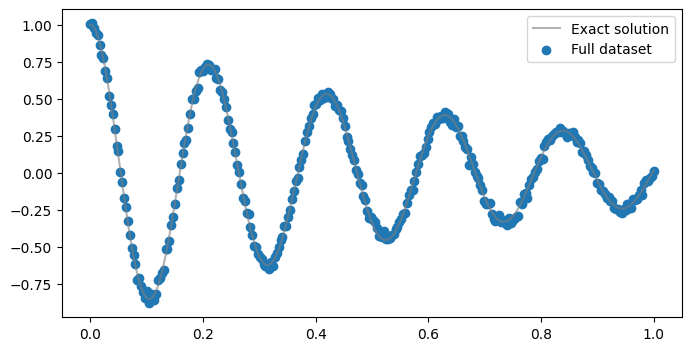

In [4]:
# Full dataset
PARAMS_CONFIG = OSCILLATION_PARAMS[1]

d = PARAMS_CONFIG['d']
w0 = PARAMS_CONFIG['w0']

data = pd.read_csv(f'./time-oscillation-d{d}-w0{w0}.csv', dtype=np.float32)

t_true = torch.linspace(0,1,500).view(-1,1)
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values).view(-1,1)
obs_data = torch.tensor(data['observation'].values).view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Full dataset")
plt.legend()
plt.show()

For simplicity, we only get a portion of data for training, as below:

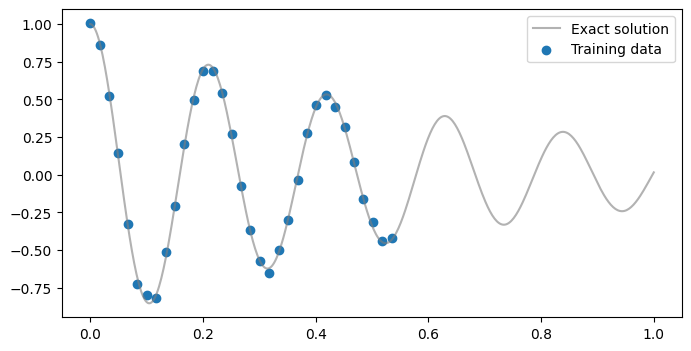

In [5]:
total = 100
percentage = 55

t_true = torch.linspace(0,1,500).view(-1,1)[:int(np.ceil(total/100*500))]
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values)[:int(np.ceil(percentage/100*len(data)))][::5].view(-1,1)
obs_data = torch.tensor(data['observation'].values)[:int(np.ceil(percentage/100*len(data)))][::5].view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

# Model and Loss functions

Please don't mind this lengthy code block

In [6]:
# qmodel = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
qmodel = Hybrid_QN(Q_DEVICE=q_device, INPUT_DIM=n_input, OUTPUT_DIM=n_output, N_QUBITS=n_qubits, N_LAYERS=n_layers, ROTATION='Rxyz').to(torch_device)
# qmodel = Pure_QN(qlayer)

/home/ncng-wsl/.local/share/virtualenvs/harmonic-oscillator-pinn-hIvsB7op/lib/python3.10/site-packages/pennylane/workflow/qnode.py:486: PennyLaneDeprecationWarning: The 'expansion_strategy' attribute is deprecated and will be removed  in version 0.39. For full control over the stage to which the tape is constructed, use the 'pennylane.workflow.construct_batch' function.
  warnings.warn(


In [7]:
# For initial condition loss
t_initial_grad = torch.tensor(0.).view(-1,1).requires_grad_(True)

t_data_grad = t_data.requires_grad_(True).to(torch_device)

t_true_grad = t_true.requires_grad_(True).to(torch_device)

obs_data_device = obs_data.to(torch_device)

# d   as above
# w0  as above
# mu = 2*d  missing
k = w0**2

mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True, device=torch_device)) # mu is missing, let's train it!
all_mus = []
all_loss =[]

learning_rate=1e-2
optimiser = torch.optim.Adam(list(qmodel.parameters()) + [mu], lr=learning_rate)

# weighting the loss functions, see block below
lambda1, lambda2, lambda3, lambda4 = 1e5, 1e5, 1, 1e5

clipper = WeightClipper()
mseloss = nn.MSELoss()

In [8]:
import os

total_params =  sum(p.numel() for p in qmodel.parameters())

path = f"./plots/d{d}-w0{w0}/PIQML_{total_params}"
if not os.path.exists(path):
    os.makedirs(path)

print(f'Sample results witll be saved to {path}')

Sample results witll be saved to ./plots/d1.5-w030/PIQML_109


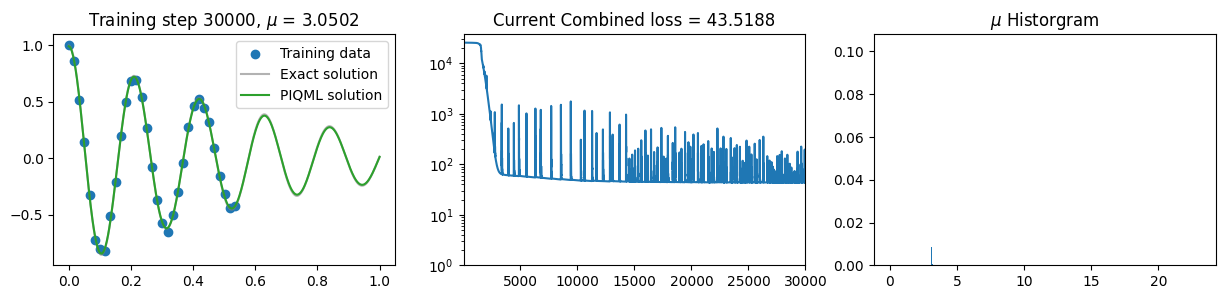


        Report on loss fns:
        - Iteration: 30000
        - Physical Loss 1: 2.103832960128784
        - MSE: 0.00041414977749809623
        
[Parameter containing:
tensor([[ -0.9727],
        [ -1.8923],
        [-14.1806],
        [  1.8768],
        [ -8.7476],
        [  5.5491]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-1.2417, -1.0553, -0.1006, -0.1848, -0.8843, -0.0115], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([[[8.7320e-01, 1.1361e+00, 2.2264e+00],
         [3.1396e+00, 1.1745e+00, 3.1413e+00],
         [2.9447e+00, 2.1760e+00, 2.9479e+00],
         [2.5472e+00, 2.9076e+00, 3.0490e+00],
         [1.5999e+00, 3.0318e+00, 1.6050e+00],
         [3.1416e+00, 3.1410e+00, 2.7540e-06]],

        [[3.0884e+00, 3.1416e+00, 3.0061e+00],
         [3.1402e+00, 2.9570e+00, 2.3946e+00],
         [9.0955e-01, 2.9513e+00, 7.8471e-01],
         [2.9991e+00, 3.1403e+00, 1.4241e+00],
         [2.6846e+00, 1.7197e+00, 2.9429e+00],

In [9]:
import time
start = time.time()

for i in range(30001):
    optimiser.zero_grad()

    # Loss function for initial conditions
    # prediction_initial = qmodel(t_initial_grad)
    # loss1, loss2 = boundary_loss(prediction_initial, t_boundary=t_initial_grad)

    # Physics loss
    prediction_extend = qmodel(t_true_grad)
    loss3 = physics_loss(prediction_extend, t_physics=t_true_grad, mu=mu, k=k)

    # # Physics loss with dataset
    # loss3 = physics_loss(prediction, t_physics=t_data_grad, mu=mu, k=k)

    # Data loss
    prediction = qmodel(t_data_grad)
    loss4 = mseloss(prediction, obs_data_device)

    # Combined
    # loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4*loss4
    loss = lambda3*loss3 + lambda4*loss4

    loss.backward()

    optimiser.step()

    qmodel.quantum_layer.apply(clipper)

    all_mus.append(mu.item())
    all_loss.append(loss.item())

    if i % 10 == 0:
        clear_output(wait=True)
        prediction = qmodel(t_true_grad).cpu()
        # plt.figure(figsize=(8,2.5))

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3), dpi=100)
        ax1.scatter(t_data.detach(), obs_data.detach(), label="Training data")
        ax1.plot(t_true.detach()[:, 0], obs_true.detach()[:, 0], label="Exact solution", color="tab:grey", alpha=0.6)
        ax1.plot(t_true.detach()[:, 0], prediction.detach()[:, 0], label="PIQML solution", color="tab:green")
        ax1.legend()
        ax1.set_title(f"Training step {i}, $\mu$ = {np.around(mu.item(), 4)}")

        ax2.plot(all_loss)
        ax2.set_xlim(1, len(all_loss))
        ax2.set_ylim(1, all_loss[0])
        ax2.set_yscale('log', base=10)

        ax2.set_title(f"Current Combined loss = {np.around(loss.item(), 4)}")

        # ax3.hist(all_mus, bins=20, weights=np.ones(len(all_mus))/len(all_mus))
        ax3.hist(all_mus, bins=np.histogram_bin_edges(all_mus, bins="fd"), weights=np.ones(len(all_mus))/len(all_mus))
        ax3.set_title(r'$\mu$ Historgram')

        plt.savefig(f'{path}/i_{i}.png', dpi=400)
        plt.show()

        print(f'''
        Report on loss fns:
        - Iteration: {i}
        - Physical Loss 1: {loss3}
        - MSE: {loss4}
        ''')
        print(list(qmodel.parameters()))  # Uncomment this to see parameters updating
    # Early stopping
    # if loss3 <= 1 and loss4 <= 0.002: break
end = time.time()

In [10]:
print(f"Time elapsed: {end - start}")

Time elapsed: 35439.34301018715


In [11]:
pd.DataFrame(all_mus).to_csv(f'{path}/PIQML_{total_params}.csv')

In [12]:
## MSE
prediction = qmodel(t_true_grad)
np.mean((harmonic_oscillator_solution(d=2, w0=20, t=t_true) - qmodel(t_true_grad).cpu()).detach().numpy())**2

0.0003690864181432642

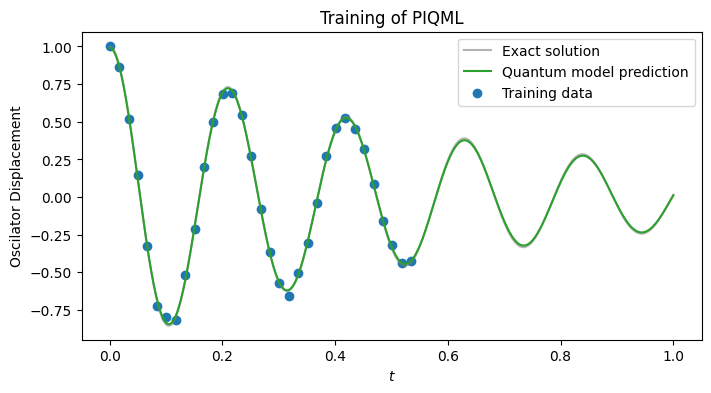

In [13]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Quantum model prediction")
    plt.scatter(x_data, y_data, label='Training data')
    plt.ylabel('Oscilator Displacement')
    plt.xlabel('$t$')
    l = plt.legend(loc='best')

plot_result(
    t_true.detach(),
    obs_true.detach(),
    t_data.detach(),
    obs_data.detach(),
    qmodel(t_true_grad).detach().cpu(),
    title='Training of PIQML'
    )

mu = Parameter containing:
tensor([3.0502], device='cuda:0', requires_grad=True)


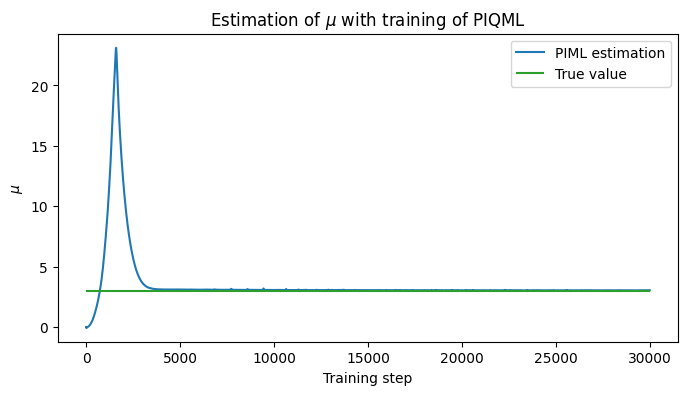

In [14]:
print(f'mu = {mu}')

plt.figure(figsize=(8,4))
plt.title("Estimation of $\mu$ with training of PIQML")
plt.plot(all_mus, label="PIML estimation")
plt.hlines(2*d, 0, len(all_mus), label="True value", color="tab:green")
plt.legend(loc='best')
plt.xlabel("Training step")
plt.ylabel("$\mu$")
plt.show()

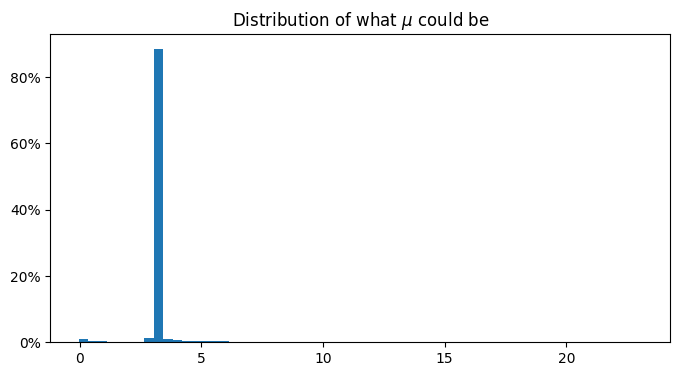

In [15]:
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(8,4))
plt.title('Distribution of what $\mu$ could be')
plt.hist(all_mus, bins=60, weights=np.ones(len(all_mus)) / len(all_mus))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()